# LangSmith and Evaluation Overview with AI Makerspace

Today we'll be looking at an amazing tool:

[LangSmith](https://docs.smith.langchain.com/)!

This tool will help us monitor, test, debug, and evaluate our LangChain applications - and more!

We'll also be looking at a few Advanced Retrieval techniques along the way - and evaluate it using LangSmith!

✋BREAKOUT ROOM #2:
- Task 1: Dependencies and OpenAI API Key
- Task 2: LangGraph RAG
- Task 3: Setting Up LangSmith
- Task 4: Examining the Trace in LangSmith!
- Task 5: Create Testing Dataset
- Task 6: Evaluation

## Task 1: Dependencies and OpenAI API Key

We'll be using OpenAI's suite of models today to help us generate and embed our documents for our simple RAG system that leverages Loand Complaint data.

In [1]:
import os
import openai
from dotenv import load_dotenv
load_dotenv(dotenv_path="../.env")
openai.api_key = os.getenv("OPENAI_API_KEY")

#### Asyncio Bug Handling

In [2]:
import nest_asyncio
nest_asyncio.apply()

## Task #2: Create a Simple RAG Application Using LangGraph

Let's remake our LangGraph RAG pipeline from the first notebook!

## LangGraph Powered RAG

First and foremost, LangChain provides a convenient way to store our chunks and their embeddings.

It's called a `VectorStore`!

We'll be using QDrant as our `VectorStore` today. You can read more about it [here](https://qdrant.tech/documentation/).

Think of a `VectorStore` as a smart way to house your chunks and their associated embedding vectors. The implementation of the `VectorStore` also allows for smarter and more efficient search of our embedding vectors - as the method we used above would not scale well as we got into the millions of chunks.

Otherwise, the process remains relatively similar under the hood!

### Data Collection

We'll be leveraging the `DirectoryLoader` to load our PDFs!

In [3]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader

directory_loader = DirectoryLoader("data", glob="**/*.pdf", loader_cls=PyMuPDFLoader)

jr_document = directory_loader.load()

jr_document[5].page_content

'“Then destroy them!”\xa0rejoined Simoun coldly.  \n“And the money to pay the laborers?”  \n“Don’t pay them! Use the prisoners and convicts!”  \n“But there aren’t\xa0enough,\xa0Señor\xa0Simoun!”  \n“Then, if there aren’t enough, let all the villagers, the old men, the youths, the boys, work. Instead of the fifteen days \nof obligatory service, let them work three, four, five months for the State, with the additional obligation that each one \nprovide his own food and tools.”  \nThe startled Don Custodio turned his head to see if there was any Indian within ear-shot, but fortunately those \nnearby were rustics, and the two helmsmen seemed to be very much occupied with the windings of the river.  \n“But,\xa0Señor\xa0Simoun—”  \n“Don’t fool yourself, Don Custodio,”\xa0continued Simoun dryly, “only in this way are great enterprises carried out \nwith small means. Thus were constructed the Pyramids, Lake Moeris, and the Colosseum in Rome. Entire provinces \ncame in from the desert, bringing

### Chunking Our Documents

Let's do the same process as we did before with our `RecursiveCharacterTextSplitter` - but this time we'll use ~200 tokens as our max chunk size!

In [4]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-4o").encode(
        text,
    )
    return len(tokens)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap = 0,
    length_function = tiktoken_len,
)
jose_rizal_chunks = text_splitter.split_documents(jr_document)

In [5]:
len(jose_rizal_chunks)

812

Let's verify the process worked as intended by checking our max document length.

In [6]:
max_chunk_length = 0

for chunk in jose_rizal_chunks:
  max_chunk_length = max(max_chunk_length, tiktoken_len(chunk.page_content))

print(max_chunk_length)

722


Perfect! Now we can carry on to creating and storing our embeddings.

### Embeddings and Vector Storage

We'll use the `text-embedding-3-small` embedding model again - and `Qdrant` to store all our embedding vectors for easy retrieval later!

In [7]:
from langchain_community.vectorstores import Qdrant
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

qdrant_vectorstore = Qdrant.from_documents(
    documents=jose_rizal_chunks,
    embedding=embedding_model,
    location=":memory:"
)

Now let's set up our retriever, just as we saw before, but this time using LangChain's simple `as_retriever()` method!

In [8]:
qdrant_retriever = qdrant_vectorstore.as_retriever()

#### Back to the Flow

We're ready to move to the next step!

### Setting up our RAG

We'll use the same LangGraph pipeline we created in the first notebook. 

Let's think through each part:

1. First we need to retrieve context
2. We need to pipe that context to our model
3. We need to parse that output

Let's start by setting up our prompt again, just so it's fresh in our minds!

Complete the prompt so that your RAG application answers queries based on the context provided, but *does not* answer queries if the context is unrelated to the query.

In [9]:
from langchain_core.prompts import ChatPromptTemplate

HUMAN_TEMPLATE = """
#CONTEXT:
{context}

QUERY:
{query}

"""
#Use the provide context to answer the provided user query. Only use the provided context to answer the query. If you do not know the answer, or it's not contained in the provided context respond with "I don't know"

# 
chat_prompt = ChatPromptTemplate.from_messages([
    ("human", HUMAN_TEMPLATE)
])

We'll set our Generator - `gpt-4.1-nano` in this case - below!

In [10]:
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-4o-mini")

#### Our RAG Application

Let's spin up the graph.

In [11]:
from langgraph.graph import START, StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser

class State(TypedDict):
  question: str
  context: list[Document]
  response: str

def retrieve(state: State) -> State:
  retrieved_docs = qdrant_retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

def generate(state: State) -> State:
  generator_chain = chat_prompt | openai_chat_model | StrOutputParser()
  response = generator_chain.invoke({"query" : state["question"], "context" : state["context"]})
  return {"response" : response}

graph_builder = StateGraph(State)
graph_builder = graph_builder.add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
rag_graph = graph_builder.compile()

Let's get a visual understanding of our chain!

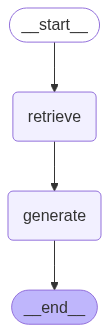

In [12]:
rag_graph

Let's test our chain out!

In [13]:
response = rag_graph.invoke({"question" : "When did the Philippines gain independence?"})
response["response"]

'The Philippines gained independence from the United States on July 4, 1946.'

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### 🎯 Breakout Room - Group Discussion: 

Why did the model answer the question even when its not related to writings of Dr. Jose Rizal?

How can you improve the prompt to respond only within the context?  
</div>

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Observations :

* This happens because there is no explicit instruction restricting it to the provided context, so it defaults to generating answers from what it already knows. To improve the prompt so it responds only within the context, you can clearly state that the model must ignore all prior or external knowledge, answer only from the provided text, and reply with “I don’t know” if the answer is not explicitly supported by the context.
</span>


## Task 3: Setting Up LangSmith (Extra! Extra!)

Now that we have a chain - we're ready to get started with LangSmith!

Create a Langsmith account here(https://smith.langchain.com/) and Setup your API key.

We're going to go ahead and use the following `env` variables to get our notebook set up to start reporting.

If all you needed was simple monitoring - this is all you would need to do!

In [14]:
from uuid import uuid4
import os
from dotenv import load_dotenv
load_dotenv(dotenv_path="../.env")

PROJECT_NAME = f"PSI AI Eng - DAY_3 - {uuid4().hex[0:8]}"

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = PROJECT_NAME

openai_api_key = os.getenv("OPENAI_API_KEY")

### LangSmith API

In order to use LangSmith - you will need an API key. You can sign up for a free account on [LangSmith's homepage!](https://www.langchain.com/langsmith)

Once you have created your account, Take the navigation option for `Settings` then `API Keys` to create an API key.

In [15]:
from langchain.callbacks import LangChainTracer
import os

os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")

tracer = LangChainTracer()
tracer.project_name = PROJECT_NAME


Let's test our our first generation!

In [16]:
result = rag_graph.invoke(
    {"question": "Who is Capitan Tiago?"},
    config={"tags": ["Demo Run"], "callbacks": [tracer]}
)

print("\nResponse:\n", result['response'])
print("\nTracing Project name:", tracer.project_name)



Response:
 Capitan Tiago, whose full name is Don Santiago de los Santos, is a character in José Rizal's novel "The Social Cancer." He is portrayed as a wealthy landlord and a prominent figure in Binondo, a district in Manila. Capitan Tiago is described as low in stature, corpulent, and appearing younger than his age, which is estimated to be between thirty and thirty-five years. He has a full face, a clear complexion, and notably white teeth, despite being a habitual user of tobacco and betel nut.

In the context of the story, he is considered one of the most hospitable men, known for hosting dinners and gatherings that attract various social climbers and sycophants. His character embodies certain societal traits and contradictions, as he is respected for his wealth but also ridiculed behind his back. The narrative explores his relationships with other characters and the socio-political dynamics of the time.

Tracing Project name: PSI AI Eng - DAY_3 - 97b920ca


## Task 4: Examining the Trace in LangSmith!

Head on over to your LangSmith web UI to check out how the trace looks in LangSmith!

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

#### 🏗️ Activity #1:

Include a screenshot of your trace and explain what it means.
</div>

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Observations :
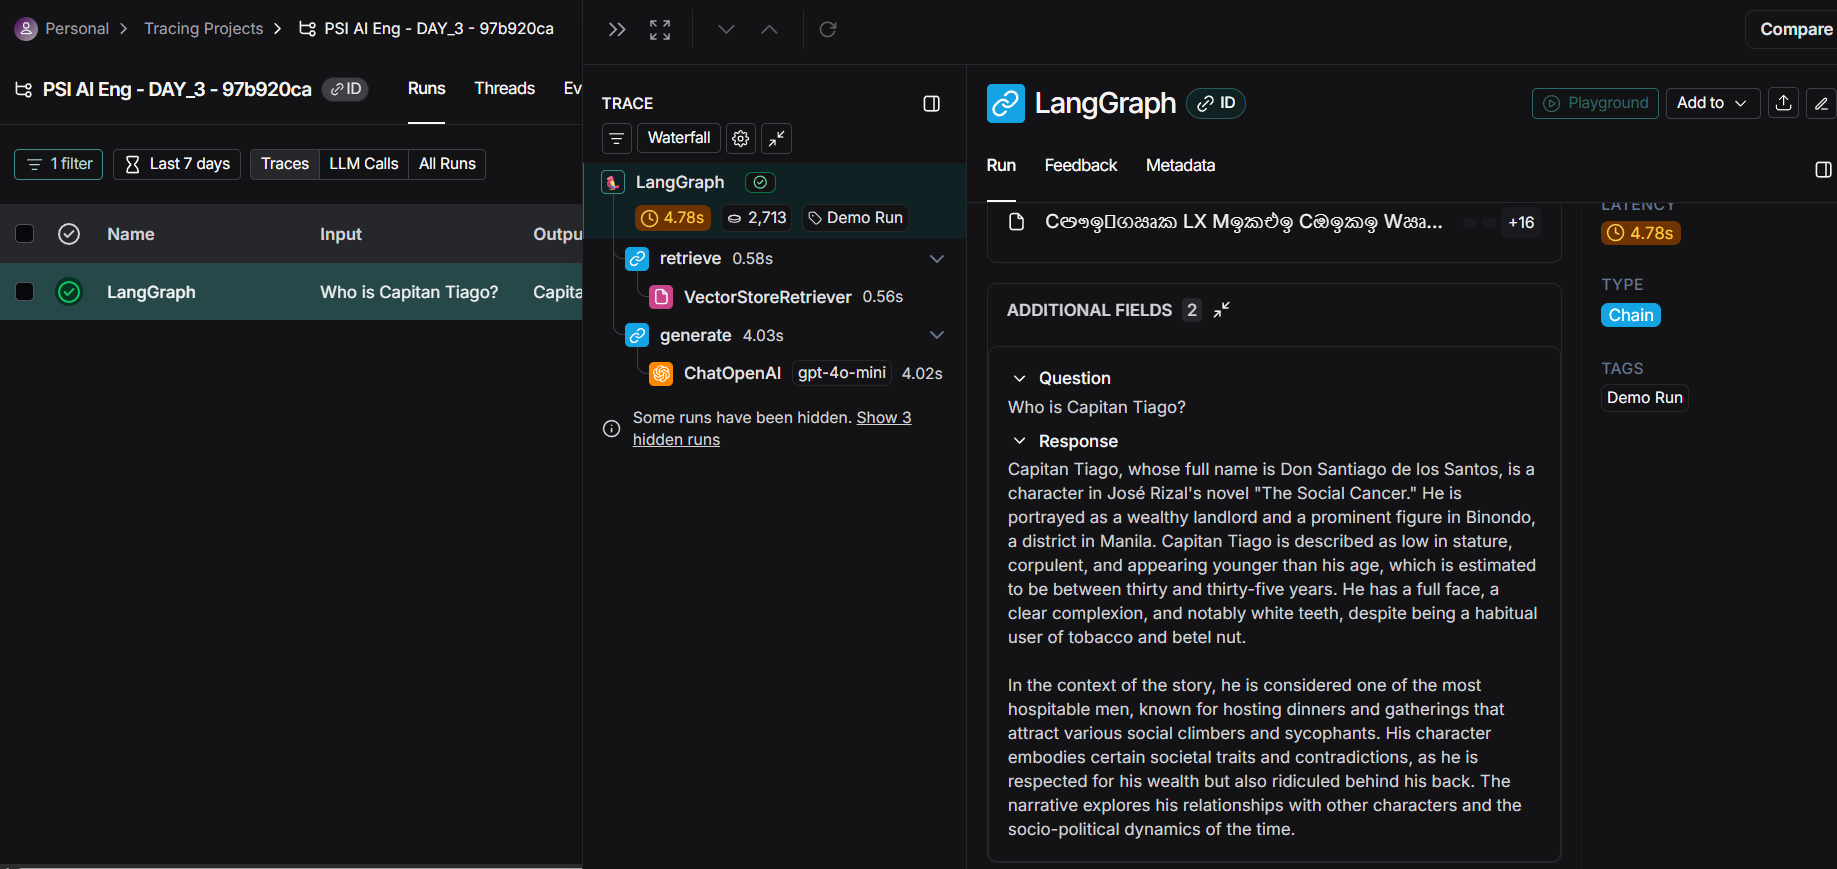
* It serves as a workspace where you can connect your LLM workflows, track their performance, debug issues, and analyze how prompts and outputs behave in real-world use.
</span>
